# The clash of Neighborhoods in Toronto City 




In the first part we will build a code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to transform the data in the table of postal codes into a pandas dataframe and then clean the data following this main steps: 

* Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
* More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that - M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the - neighborhoods separated with a comma as shown in row 11 in the above table.
* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
* Use the .shape method to print the number of rows of your dataframe.

In [18]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [20]:
List_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(List_url).text

In [21]:
soup = BeautifulSoup(source, 'xml')
table = soup.find('table')

In [22]:
#dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)

In [23]:
# Search all the data
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


## Data cleaning 

In [24]:
# Get index where Borough = Not assigned and Drop the row
df.drop(labels = df[df['Borough']=='Not assigned'].index, axis = 0, inplace = True)
df.head()

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [25]:
# Make sure that if a cell has a borough but a 'Not assigned' neighborhood, then the neighborhood will be the same as the borough
df.loc[(df.Neighborhood == 'Not assigned'),'Neighborhood']=df['Borough']
df.head()

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [26]:
# Make sure than no more than one neighborhood can exist in one postal code area by groupind them and separate them by a coma
df = df.groupby('Postalcode').agg({'Borough' : 'first', 'Neighborhood' : ','.join}).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [27]:
# Verify that all Postalcode data are now unique
boolean = df['Postalcode'].duplicated().any()
print(boolean)

False


In [28]:
print("The final shape of the dataframe is :", df.shape)

The final shape of the dataframe is : (103, 3)


## Getting latitude and longitude coordinates 

In the second part of this notebook we will creat a new dataframe with  the latitude and the longitude coordinates of each neighborhood. 

In [29]:
# Create a loop to get the coordinates

def get_geocode(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

In [30]:
# Get the dataset that includes latitude and longitude coordinates for each neighborhood 
df_geo=pd.read_csv('http://cocl.us/Geospatial_data')
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [32]:
# Merge the dataframe with latitude and longitude coordinates and the previous dataframe
df_geo.rename(columns={'Postal Code':'Postalcode'},inplace=True)
df_merge = pd.merge(df_geo, df, on='Postalcode')
df_tot = df_merge[['Postalcode','Borough','Neighborhood','Latitude','Longitude']]
df_tot.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Segmenting and Clustering Neighborhoods

In the third part of this notebook we will generate a map to visualize our neighborhoods and how they are clustered together. We will then explore each neighborhood and create a dataframe than contains all the venues depicted in each of them.

In [33]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#conda config --append channels conda-forge

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library

import sys
!{sys.executable} -m pip install reverse_geocoder
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

Libraries imported.


In [35]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_tot['Borough'].unique()),
        df_tot.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


### Create a map of Toronto with neighborhoods superimposed on top

In [36]:
# Get latitude and longitude coordinates of Toronto City

address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 25.7933414, -100.2740662.


In [38]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_tot['Latitude'], df_tot['Longitude'], df_tot['Borough'], df_tot['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [44]:
# Define Foursquare Credentials and Version

LIMIT = 100

CLIENT_ID = 'PXNGKJNS1KJ23E5I4MF1H1TW0K4FPJ50M1JZHXPJCN0QNN1Q' # your Foursquare ID
CLIENT_SECRET = 'R1PH2KT1WRSKXTZ5J20AMRLGTU2HOB5UFCT0HP124YBS13CI' # your Foursquare Secret
ACCESS_TOKEN = 'JVF5MPJBK1NWV355XZD0LC1USC2SEVS4LASKVPPJOSWAYODN' # your FourSquare Access Token
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PXNGKJNS1KJ23E5I4MF1H1TW0K4FPJ50M1JZHXPJCN0QNN1Q
CLIENT_SECRET:R1PH2KT1WRSKXTZ5J20AMRLGTU2HOB5UFCT0HP124YBS13CI


### Explore all neighborhoods and analyzing the data 

We will now explore neighborhood by neighborhood in the city of Toronto and retreive neighborhood's name, latitude and longitude values and all venues in the given neighborhood.

In [45]:
#create a function loop over all the neighborhoods in Toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [147]:
# run the above function on each neighborhood and create a new dataframe called toronto_venues
toronto_venues = pd.DataFrame(getNearbyVenues(names=df_tot['Neighborhood'],
                                   latitudes=df_tot['Latitude'],
                                   longitudes=df_tot['Longitude'],
                                  ))

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [136]:
# We will print the size of the new dataframe toronto_venues and see more about this dataframe
print(toronto_venues.shape)
toronto_venues.head()

(2141, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [137]:
# General informations
print('There are {} venues in Toronto.'.format(toronto_venues['Venue Category'].count()))
print('There are {} uniques categories of venue.'.format(len(toronto_venues['Venue Category'].unique())))
print('There are {} uniques Neighborhood.'.format(len(toronto_venues['Neighborhood'].unique())))

There are 2141 venues in Toronto.
There are 273 uniques categories of venue.
There are 96 uniques Neighborhood.


In [159]:
# Count the number of total venue in each Neighborhood
venues_tot = toronto_venues.groupby('Neighborhood').count()
venues_tot.sort_values('Venue',ascending=False,inp lace=True)
venues_tot.drop(labels=['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude','Venue Category'], axis=1, inplace=True)
venues_tot.head()

,Venue
Neighborhood,
"Toronto Dominion Centre, Design Exchange",100
"Richmond, Adelaide, King",100
"Harbourfront East, Union Station, Toronto Islands",100
"Garden District, Ryerson",100
"First Canadian Place, Underground city",100


In [167]:
# Take the top 20 of Neighborhood in Toronto city that count the higher number of venues 
venues_top20 = venues_tot.head(20)
venues_temp = toronto_venues.groupby('Neighborhood').agg({'Venue Category': 'first', 'Venue Category' : ','.join}).reset_index()
venues_temp.head(20)

#Let's explore the first neighborhood in terms of higher number of venue  

Calgary_venues_NE = venues_temp[venues_temp.Neighborhood=='Toronto Dominion Centre, Design Exchange']
Calgary_venues_NE

,Neighborhood,Venue Category
83,"Toronto Dominion Centre, Design Exchange","Restaurant,Coffee Shop,Pub,Gym,Hotel,Bakery,Ca..."


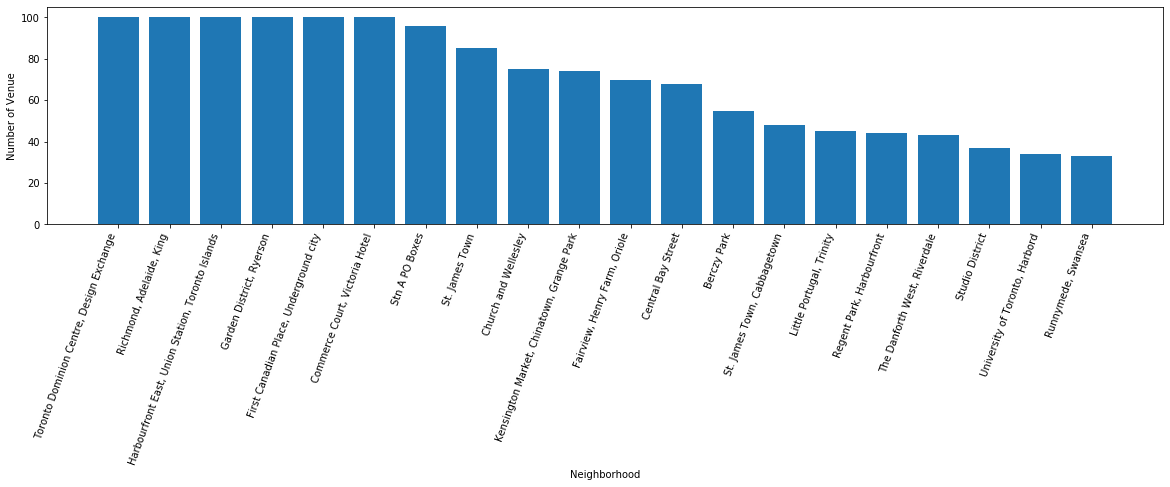

In [119]:
import matplotlib.pyplot as plt

#plot a bar graph to see which neighborhoods have the most restaurants

bar_graph_data=pd.DataFrame(venues_top20['Venue']).reset_index()
x=bar_graph_data.iloc[:,0]
y=bar_graph_data.iloc[:,1]

plt.figure(figsize=(20,4))
plt.bar(x, y)

#plot labels and titles
plt.xlabel('Neighborhood')
plt.xticks(rotation=70, ha='right')
plt.ylabel('Number of Venue')

plt.show()

## Analizing and Clustering of Neighborhoods

In [172]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [173]:
# Examine the new data frame
toronto_onehot.shape

(2141, 273)

In [174]:
# Here rows are grouped by neighborhood by taking the mean of the frequency of occurrence of each category

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0                     Lounge   0.2
1             Breakfast Spot   0.2
2               Skating Rink   0.2
3  Latin American Restaurant   0.2
4             Clothing Store   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.29
1        Pharmacy  0.14
2             Gym  0.14
3  Sandwich Place  0.14
4             Pub  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
                venue  freq
0         Coffee Shop  0.10
1                Bank  0.10
2  Chinese Restaurant  0.05
3    Sushi Restaurant  0.05
4         Gas Station  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Café  0.25
2   Chinese Restaurant  0.25
3                 Bank  0.25
4                Motel  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.09
1  Italian Restaurant  0.09
2         Coffee Shop  0.09
3            

In [175]:
# We will write a function to sort the venues and then create a new dataframe and display the top 10 venues for each neighborhood.

import numpy as np 

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Latin American Restaurant,Breakfast Spot,Clothing Store,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Pharmacy,Coffee Shop,Sandwich Place,Pub,Women's Store,Dog Run,Dim Sum Restaurant,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Mobile Phone Shop,Bridal Shop,Sandwich Place,Diner,Restaurant,Deli / Bodega,Supermarket,Middle Eastern Restaurant
3,Bayview Village,Café,Japanese Restaurant,Chinese Restaurant,Bank,Women's Store,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Greek Restaurant,Sushi Restaurant,Pharmacy,Pizza Place,Pub,Café,Butcher


We will now group run a k-means algortithm to cluster the neighborhoods into 5 separate clusters.

In [176]:
# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [177]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_tot

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,4.0,Fast Food Restaurant,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Wings Joint
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,3.0,Construction & Landscaping,Bar,Women's Store,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Restaurant,Medical Center,Intersection,Mexican Restaurant,Bank,Rental Car Location,Breakfast Spot,Electronics Store,Drugstore,Donut Shop
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Mexican Restaurant,Korean BBQ Restaurant,Women's Store,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Hakka Restaurant,Athletics & Sports,Bakery,Gas Station,Caribbean Restaurant,Thai Restaurant,Bank,Fried Chicken Joint,Dog Run,Distribution Center


In [178]:
# Map all clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


## Examine Clusters 1 to 5

### Cluster 1

In [179]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,North York,0.0,Athletics & Sports,Mediterranean Restaurant,Dog Run,Golf Course,Pool,Diner,Discount Store,Distribution Center,Doner Restaurant,Donut Shop
90,Etobicoke,0.0,River,Pool,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore


### Cluster 2

In [180]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,1.0,Restaurant,Medical Center,Intersection,Mexican Restaurant,Bank,Rental Car Location,Breakfast Spot,Electronics Store,Drugstore,Donut Shop
3,Scarborough,1.0,Coffee Shop,Mexican Restaurant,Korean BBQ Restaurant,Women's Store,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,Scarborough,1.0,Hakka Restaurant,Athletics & Sports,Bakery,Gas Station,Caribbean Restaurant,Thai Restaurant,Bank,Fried Chicken Joint,Dog Run,Distribution Center
5,Scarborough,1.0,Smoke Shop,Playground,Jewelry Store,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
6,Scarborough,1.0,Department Store,Coffee Shop,Hobby Shop,Train Station,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
7,Scarborough,1.0,Bus Line,Bakery,Soccer Field,Ice Cream Shop,Metro Station,Bus Station,Intersection,Park,Drugstore,Donut Shop
8,Scarborough,1.0,Motel,American Restaurant,Women's Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
9,Scarborough,1.0,College Stadium,Skating Rink,General Entertainment,Café,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
10,Scarborough,1.0,Indian Restaurant,Pet Store,Vietnamese Restaurant,Chinese Restaurant,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
11,Scarborough,1.0,Auto Garage,Middle Eastern Restaurant,Sandwich Place,Bakery,Smoke Shop,Accessories Store,Concert Hall,Construction & Landscaping,Event Space,Ethiopian Restaurant


### Cluster 3

In [181]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,2.0,Park,Playground,Bakery,Intersection,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Dessert Shop
23,North York,2.0,Park,Convenience Store,Women's Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
25,North York,2.0,Food & Drink Shop,Park,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Women's Store
40,East York,2.0,Intersection,Park,Convenience Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
44,Central Toronto,2.0,Park,Swim School,Bus Line,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore,Dim Sum Restaurant
50,Downtown Toronto,2.0,Park,Playground,Trail,Escape Room,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Department Store
74,York,2.0,Park,Women's Store,Pool,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
79,North York,2.0,Park,Construction & Landscaping,Bakery,Women's Store,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
98,York,2.0,Park,Women's Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


### Cluster 4

In [182]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,3.0,Construction & Landscaping,Bar,Women's Store,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
91,Etobicoke,3.0,Baseball Field,Construction & Landscaping,Women's Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
97,North York,3.0,Baseball Field,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Women's Store,Fast Food Restaurant


### Cluster 5

In [82]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,4.0,Fast Food Restaurant,Donut Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Drugstore,Farmers Market


### Cluster 6 

In [183]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,North York,5.0,Martial Arts School,Women's Store,Drugstore,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


### Cluster 7 

In [184]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,Etobicoke,6.0,Print Shop,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dessert Shop
